# Exploratory Data Analysis - Geodata

## Setup

### Imports

In [1]:
from datetime import tzinfo, timedelta, datetime

import matplotlib.pyplot as plt
import pandas as pd
import folium

from folium import plugins as plugins

### Loading and Cleaning Data

We replace the string in the timestamp with a DateTime object, and set the timestamp as an index. We set convert the UTC timestamps to EST (the time at which the attacks occured).

In [2]:
df = pd.read_csv('../data/parler-videos-geocoded.csv')
df['Timestamp'] = df['Timestamp'].map(lambda x: datetime.fromisoformat(x))
df = df.set_index('Timestamp')
df = df.tz_localize('UTC').tz_convert('EST')
df.head()

,Longitude,Latitude,ID
Timestamp,,,
2010-08-08 16:44:38-05:00,0.0000,0.0000,PtowPIzpewhu
2011-03-19 11:48:35-05:00,0.0000,0.0000,dGOhNqNgNywF
2011-08-01 17:22:40-05:00,-118.8878,39.5554,RGTLwBQugFNU
2011-11-11 16:36:54-05:00,-74.6049,39.3308,YNBV5GZkeM2E
2012-12-24 17:50:15-05:00,-101.8747,33.4269,oqLyjjYghOMi


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68284 entries, 2010-08-08 16:44:38-05:00 to 2021-01-10 09:30:29-05:00
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  68284 non-null  float64
 1   Latitude   68284 non-null  float64
 2   ID         68284 non-null  object 
dtypes: float64(2), object(1)
memory usage: 2.1+ MB


## Exploratory Data Analysis

### Distribution in Time of the Metadata

First, we simply look at how many videos are availble for each month, from the creation of the website to its end.

In [4]:
df.groupby(df.index.year).count().rename(columns={'ID': 'Videos'})[['Videos']]

,Videos
Timestamp,
2010,1
2011,3
2012,2
2013,14
2014,17
2015,34
2016,74
2017,172
2018,356


We can see that most videos were posted in the last two years of the social network. Let's look at that more in detail.

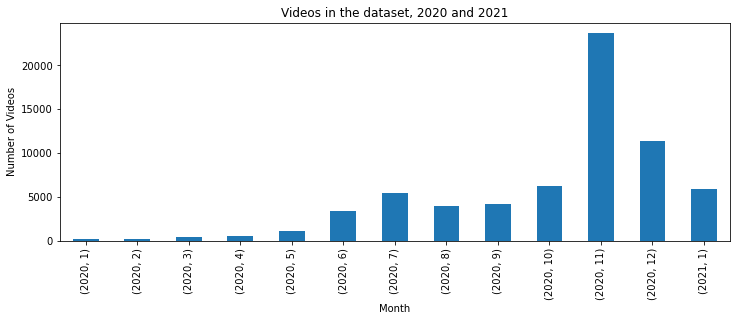

In [5]:
df_recent = df[df.index.year >= 2020]
df_recent.groupby([df_recent.index.year, df_recent.index.month]).count()['ID']\
    .plot(kind='bar', title='Videos in the dataset, 2020 and 2021',
          xlabel='Month', ylabel='Number of Videos', figsize=(12, 4))
plt.show()

Unsurprisingly, most of the data comes from November 2020 (the month in which the US Presidential election occured) and January 2021 (there is not as much data as in November, but Parler was taken down on the 10th of January so the number of videos is over a much shorter time span).

We then want to look at videos posted around Washington D.C., during the attacks on the Capitol.

In [6]:
df_06_01_2021 = df_recent[(df_recent.index.year == 2021) &\
                          (df_recent.index.month == 1) &\
                          (df_recent.index.day == 6)]

df_dc_attack = df_06_01_2021[(df_06_01_2021['Longitude'] >= -77.6349) &\
                             (df_06_01_2021['Longitude'] <= -76.4803) &\
                             (df_06_01_2021['Latitude'] >= 38.5572) &\
                             (df_06_01_2021['Latitude'] <= 39.2300)]

print(f'Videos taken around Washington D.C., 2021-01-06: {len(df_dc_attack)}')

Videos taken around Washington D.C., 2021-01-06: 1225


### Locations of Videos

As folium maps aren't rendered on Github, a static image was added for the static maps. To view the dynamic maps, you must download the notebook and "trust" it, but don't need to rerun the cells.

#### USA

We then look at the distribution of the videos over the USA.

In [7]:
usa_map_setup = {
    'Latitude': 37.0902,
    'Longitude': -95.7129,
    'Zoom': 4,
}

heatmap_usa = folium.Map(
    location=[usa_map_setup['Latitude'], usa_map_setup['Longitude']],
    zoom_start=usa_map_setup['Zoom'])
usa_heatmap_data = [[row['Latitude'], row['Longitude']] for index, row in df.iterrows()]

plugins.HeatMap(
    usa_heatmap_data,
    radius=5,
    gradient={0.2: 'blue', 0.3: 'lime', 0.4: 'red'},
).add_to(heatmap_usa)

heatmap_usa

![Heatmap of videos taken around Washington, D.C. on January 6th, 2021](../data/folium_usa_map.png)

#### Capitol Attacks

We the plot the videos taken around Washington D.C. during the attack of the Capitol.

In [8]:
heatmap_dc = folium.Map(location=[38.89, -77.03], zoom_start=12) 
dc_heat_data = [[row['Latitude'], row['Longitude']] for index, row in df_dc_attack.iterrows()]
plugins.HeatMap(
    dc_heat_data,
    radius=10,
    gradient={0.2: 'blue', 0.5: 'lime', 0.8: 'red'},
).add_to(heatmap_dc)

heatmap_dc

![Heatmap of videos taken around Washington, D.C. on January 6th, 2021](../data/folium_dc_map.png)